# Laboratorio 5
## Data Science
#### Sección 40
Javier Alejandro Ovalle Chiquín, 22103  
José Ángel Morales Farfán, 22689  
Ricardo Josué Morales Contreras, 22289

In [14]:
# ==== Librerías a usar en el Paso 2 ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Shape del dataset: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
----------------------------
Duplicados por id: 0
Duplicados por texto: 110
----------------------------

Balance de clases (target):
target
0    4342
1    3271
Name: count, dtype: int64
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64
----------------------------

Estadísticas de longitud:
count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%      

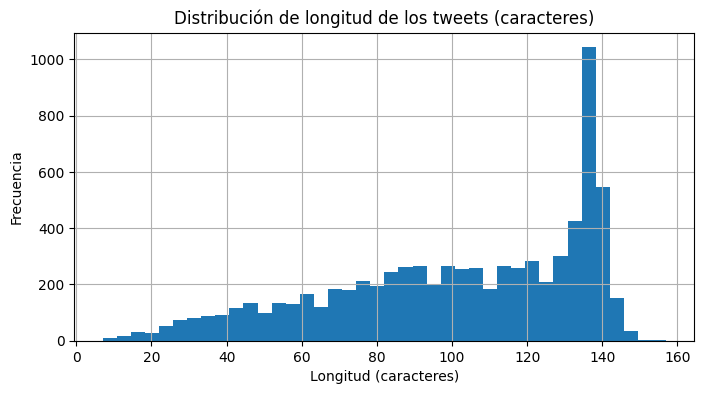

In [15]:
# ==== Cargar CSV ====
df = pd.read_csv("tweets.csv")   # ajusta la ruta si no está en el mismo folder

# ==== Vista rápida ====
print("Shape del dataset:", df.shape)
display(df.head())

# ==== Info de columnas ====
print("\nTipos de datos y nulos:")
print(df.info())
print(df.isna().sum())
print("----------------------------")

# ==== Revisar duplicados ====
dup_id = df["id"].duplicated().sum()
dup_text = df["text"].duplicated().sum()
print(f"Duplicados por id: {dup_id}")
print(f"Duplicados por texto: {dup_text}")
print("----------------------------")

# ==== Balance de clases ====
print("\nBalance de clases (target):")
print(df["target"].value_counts())
print(df["target"].value_counts(normalize=True)*100)
print("----------------------------")

# ==== Estadísticas de longitud de texto ====
df["text_len"] = df["text"].astype(str).str.len()
print("\nEstadísticas de longitud:")
print(df["text_len"].describe())
print("----------------------------")

# Histograma de longitudes
plt.figure(figsize=(8,4))
df["text_len"].hist(bins=40)
plt.title("Distribución de longitud de los tweets (caracteres)")
plt.xlabel("Longitud (caracteres)")
plt.ylabel("Frecuencia")
plt.show()

Lo que se hace aquí es limpiar el data set (versión preeliminar)

In [16]:
import pandas as pd
import re
import html
import numpy as np

# === Función de limpieza ===
def clean_text_for_classification(text: str) -> str:
    text = str(text)
    text = html.unescape(text)       # decodificar entidades HTML (&amp;)
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)                  # eliminar HTML
    text = re.sub(r"http\S+|www\.\S+", " ", text)       # eliminar URLs
    text = re.sub(r"@\w+", " ", text)                   # eliminar menciones
    text = text.replace("#", " ")                       # quitar '#' pero dejar palabra
    text = re.sub(r"[^\x00-\x7F]+", " ", text)          # quitar no-ASCII
    # preservar "911" explícitamente
    text = re.sub(r"\b911\b", " nineoneone_token ", text)
    text = re.sub(r"\d+", " ", text)                    # eliminar números
    text = re.sub(r"nineoneone_token", " 911 ", text)
    text = re.sub(r"[^\w\s]", " ", text)                # quitar puntuación
    text = re.sub(r"\s+", " ", text).strip()            # normalizar espacios
    return text

# === 3. Crear la columna text_clean ===
df["text_clean"] = df["text"].astype(str).apply(clean_text_for_classification)


In [17]:
print(df.columns)

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len',
       'text_clean'],
      dtype='object')


Ahora se va a verificar las keywords, además de crear una columna secundaría de keywords para tener un argumento más robusto a la hora de verificar si el comentario es relacionado con un desastre o no 

In [18]:
# === 4. Preparar lista de keywords ===
keyword_list = df["keyword"].dropna().unique().tolist()
keyword_list = [k.lower().replace("%20", " ") for k in keyword_list]

extra_keywords = ["evacuation", "rescue", "explosion", "emergency", "burning"]
keywords = sorted(set(keyword_list + extra_keywords))

# === 5. Función para buscar keywords ===
def find_keywords(text, keyword_set):
    found = []
    for kw in keyword_set:
        if re.search(r"\b" + re.escape(kw) + r"\b", text):
            found.append(kw)
    return found

# === 6. Crear columnas de keywords ===
df["keywords_found"] = df["text_clean"].apply(lambda x: find_keywords(str(x), keywords))
df["keyword_primary"] = df["keywords_found"].apply(lambda x: x[0] if len(x) > 0 else np.nan)
df["keyword_secondary"] = df["keywords_found"].apply(lambda x: x[1] if len(x) > 1 else np.nan)

# === 7. Ver resultado ===
print(df[["text", "text_clean", "keywords_found", "keyword_primary", "keyword_secondary"]].head(10))


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   
5  #RockyFire Update => California Hwy. 20 closed...   
6  #flood #disaster Heavy rain causes flash flood...   
7  I'm on top of the hill and I can see a fire in...   
8  There's an emergency evacuation happening now ...   
9  I'm afraid that the tornado is coming to our a...   

                                          text_clean  \
0  our deeds are the reason of this earthquake ma...   
1              forest fire near la ronge sask canada   
2  all residents asked to shelter in place are be...   
3  people receive wildfires evacuation orders in ...   
4  just got sent this photo from ruby alaska as s...   
5  rockyfire update california hwy closed in bo